In [1]:
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# Let's try reading the CSV file using a semicolon as the delimiter
got_df = pd.read_csv("Game_of_Thrones_Script.csv", delimiter=';')

# Display the first few rows of the dataframe to understand its structure
got_df.head()

Release Date    Season    Episode     Episode Title          Name  \
0   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
1   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
2   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
3   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
4   2011-04-17  Season 1  Episode 1  Winter is Coming         gared   

                                            Sentence  
0  What do you expect? They're savages. One lot s...  
1  I've never seen wildlings do a thing like this...  
2                             How close did you get?  
3                            Close as any man would.  
4                   We should head back to the wall.

In [2]:
# Getting the unique names
unique_characters = got_df['Name'].unique()

# Providing the complete list of unique characters
unique_characters_list = list(unique_characters)

# Displaying the total number of unique characters
total_characters = len(unique_characters_list)
total_characters, unique_characters_list

(520,
 ['waymar royce',
  'will',
  'gared',
  'jon snow',
  'septa mordane',
  'sansa stark',
  'eddard stark',
  'robb stark',
  'jonrobb',
  'rodrik cassel',
  'catelyn stark',
  'bran stark',
  'theon greyjoy',
  'jaime lannister',
  'cersei lannister',
  'maester luwin',
  'luwin',
  'arya stark',
  'robert baratheon',
  'tyrion lannister',
  'ros',
  'viserys targaryen',
  'daenerys targaryen',
  'maid',
  'illyrio',
  'benjen stark',
  'a voice',
  'jorah mormont',
  'drogo',
  'sandor clegane',
  'doreah',
  'irri',
  'joffrey lannister',
  'myrcella baratheon',
  'assassin',
  'jhiqui',
  'mycah',
  'soldier',
  'jory cassel',
  'kings landing guard',
  'varys',
  'renly baratheon',
  'petyr baelish',
  'grand maester pycelle',
  'old nan',
  'guard',
  'alliser thorne',
  'jeor mormont',
  'grenn',
  'pyp',
  'rast',
  'barristan selmy',
  'lancel lannister',
  'rakharo',
  'yoren',
  'maester aemon',
  'syrio forel',
  'sam',
  'janos slynt',
  'hugh of vale',
  'tobho mott'

In [3]:
# Load the dataset
got_df = pd.read_csv('Game_of_Thrones_Script.csv', delimiter=';')

# Function to process a batch of lines
def process_batch(batch):
    character_counts = Counter(batch['Name'])
    interactions = [(char1, char2) for char1 in character_counts for char2 in character_counts if char1 != char2 and character_counts[char1] > 1 and character_counts[char2] > 1]
    return interactions

# Function to process each episode
def process_episode(episode_df):
    interactions = []
    for start in range(0, len(episode_df), 10):
        batch = episode_df.iloc[start:start + 10]
        batch_interactions = process_batch(batch)
        interactions.extend(batch_interactions)
    return interactions

# Analyze each season and episode
seasons = got_df['Season'].unique()
season_graphs = {}

for season in seasons:
    season_df = got_df[got_df['Season'] == season]
    episodes = season_df['Episode'].unique()
    season_interactions = Counter()

    for episode in episodes:
        episode_df = season_df[season_df['Episode'] == episode]
        interactions = process_episode(episode_df)
        season_interactions.update(interactions)

    # Create a graph for the season
    G = nx.Graph()
    for (char1, char2), count in season_interactions.items():
        G.add_edge(char1, char2, weight=count)
    
    season_graphs[season] = G


In [4]:
def process_episode_with_rolling_window_unique(episode_df):
    interactions = Counter()
    num_lines = len(episode_df)

    for i in range(num_lines):
        window_end = min(i + 11, num_lines)
        window_df = episode_df.iloc[i:window_end]

        character_counts = Counter(window_df['Name'])
        interacting_characters = [char for char, count in character_counts.items() if count > 1]

        # Update interactions count for each unique pair of interacting characters
        for index, char1 in enumerate(interacting_characters):
            for char2 in interacting_characters[index + 1:]:
                interactions[frozenset([char1, char2])] += 1

    return interactions

# Processing each episode in each season with the revised approach
season_interactions_unique = {}
for season in got_df['Season'].unique():
    season_df = got_df[got_df['Season'] == season]
    season_interactions_unique[season] = Counter()

    for episode in season_df['Episode'].unique():
        episode_df = season_df[season_df['Episode'] == episode]
        episode_interactions = process_episode_with_rolling_window_unique(episode_df)
        season_interactions_unique[season].update(episode_interactions)

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1)
top_10_interactions_season_1_unique = season_interactions_unique['Season 1'].most_common(10)
print(top_10_interactions_season_1_unique)

[(frozenset({'eddard stark', 'robert baratheon'}), 211), (frozenset({'daenerys targaryen', 'jorah mormont'}), 169), (frozenset({'eddard stark', 'petyr baelish'}), 165), (frozenset({'eddard stark', 'cersei lannister'}), 144), (frozenset({'eddard stark', 'arya stark'}), 141), (frozenset({'sam', 'jon snow'}), 138), (frozenset({'tyrion lannister', 'shae'}), 99), (frozenset({'robb stark', 'catelyn stark'}), 97), (frozenset({'cersei lannister', 'robert baratheon'}), 94), (frozenset({'bronn', 'tyrion lannister'}), 88)]


In [5]:
## Filtering out too-general characters from the interactions
# Re-defining the list of non-specific character names to remove
non_specific_characters = [
    "man", "woman", "soldier", "guard", "all", "wife", "male voice", "female voice", "prostitute", "crowd",
    "militant", "thin man", "banker", "girl", "boy", "old man", "young man", "men", "women", "dying man",
    "child", "wildling", "stark guard", "populace", "maid", "storyteller", "kings landing page"
]

# Re-defining the function to filter out non-specific characters from the interactions
def filter_interactions(interactions):
    filtered_interactions = Counter()
    for pair, count in interactions.items():
        # Ensure both characters in the pair are not in the non-specific list
        if not any(char in non_specific_characters for char in pair):
            filtered_interactions[pair] = count
    return filtered_interactions

# Apply the filter to each season's interactions
filtered_season_interactions = {}
for season in season_interactions_unique:
    filtered_season_interactions[season] = filter_interactions(season_interactions_unique[season])

# Example: Displaying the top 10 interactions for a specific season (e.g., Season 1) after filtering
filtered_top_10_season_1 = filtered_season_interactions['Season 1'].most_common(10)
filtered_top_10_season_1

[(frozenset({'eddard stark', 'robert baratheon'}), 211),
 (frozenset({'daenerys targaryen', 'jorah mormont'}), 169),
 (frozenset({'eddard stark', 'petyr baelish'}), 165),
 (frozenset({'cersei lannister', 'eddard stark'}), 144),
 (frozenset({'arya stark', 'eddard stark'}), 141),
 (frozenset({'jon snow', 'sam'}), 138),
 (frozenset({'shae', 'tyrion lannister'}), 99),
 (frozenset({'catelyn stark', 'robb stark'}), 97),
 (frozenset({'cersei lannister', 'robert baratheon'}), 94),
 (frozenset({'bronn', 'tyrion lannister'}), 88)]

In [6]:
# # Saving all interactions per season into an xlsx file
# def create_interaction_dataframe_filtered(interactions):
#     # Converting interaction data to a format suitable for DataFrame
#     data = [{'Characters': '-'.join(str(char) for char in pair), 'Interactions': count}
#             for pair, count in interactions.items()]
#     df = pd.DataFrame(data)

#     # Sorting by interaction count in descending order
#     df = df.sort_values(by='Interactions', ascending=False)
#     return df

# # Creating DataFrames for each season with filtered interactions and saving to an Excel file with multiple sheets
# with pd.ExcelWriter('Game_of_Thrones_Filtered_Interactions.xlsx') as writer:
#     for season in filtered_season_interactions:
#         df = create_interaction_dataframe_filtered(filtered_season_interactions[season])
#         df.to_excel(writer, sheet_name=season, index=False)

# # The Excel file 'Game_of_Thrones_Filtered_Interactions.xlsx' is in the current directory, no need to run this code anymore

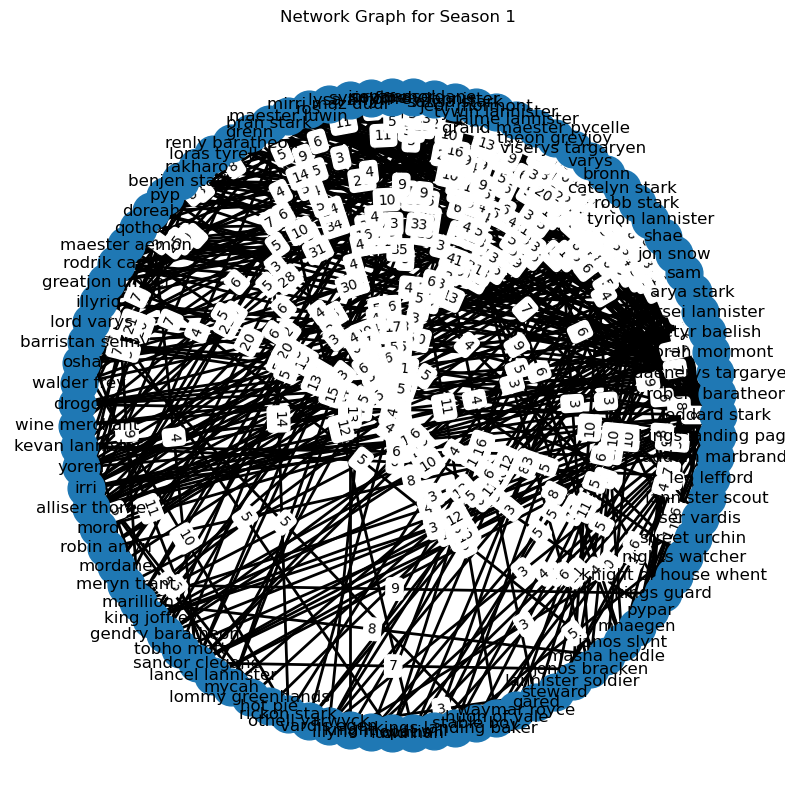

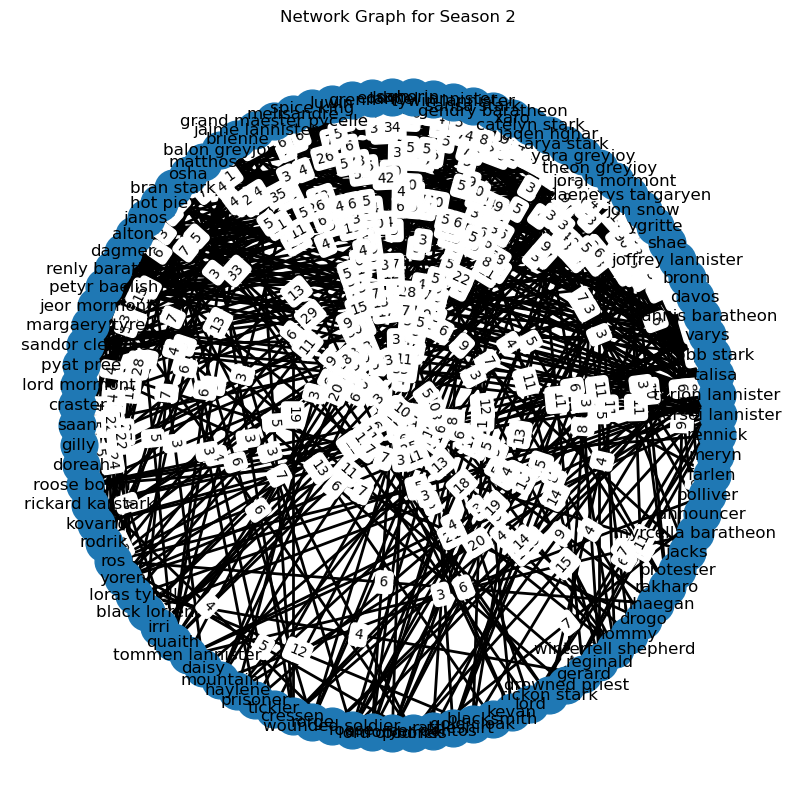

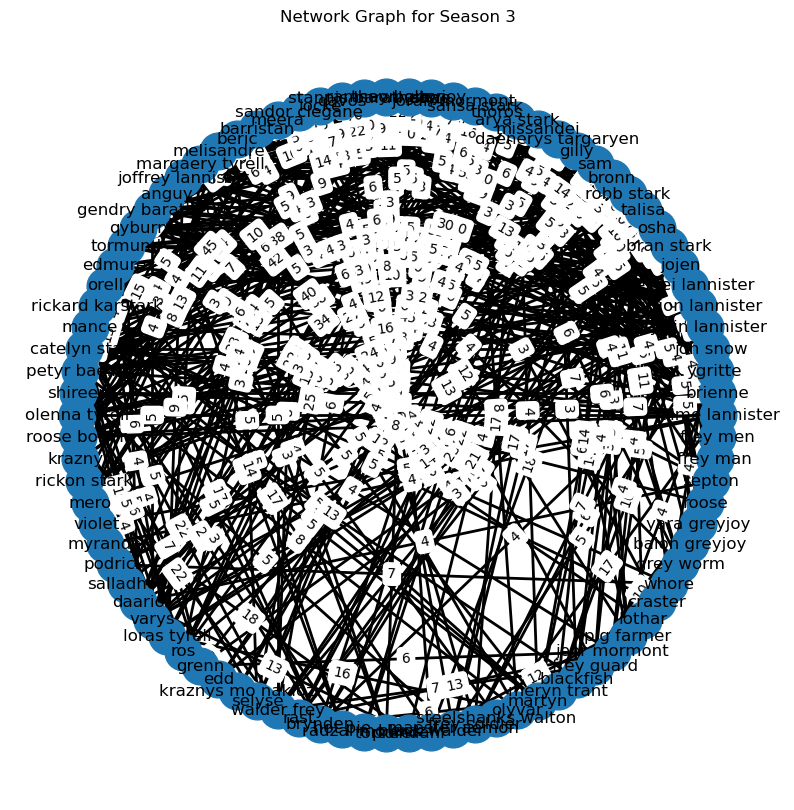

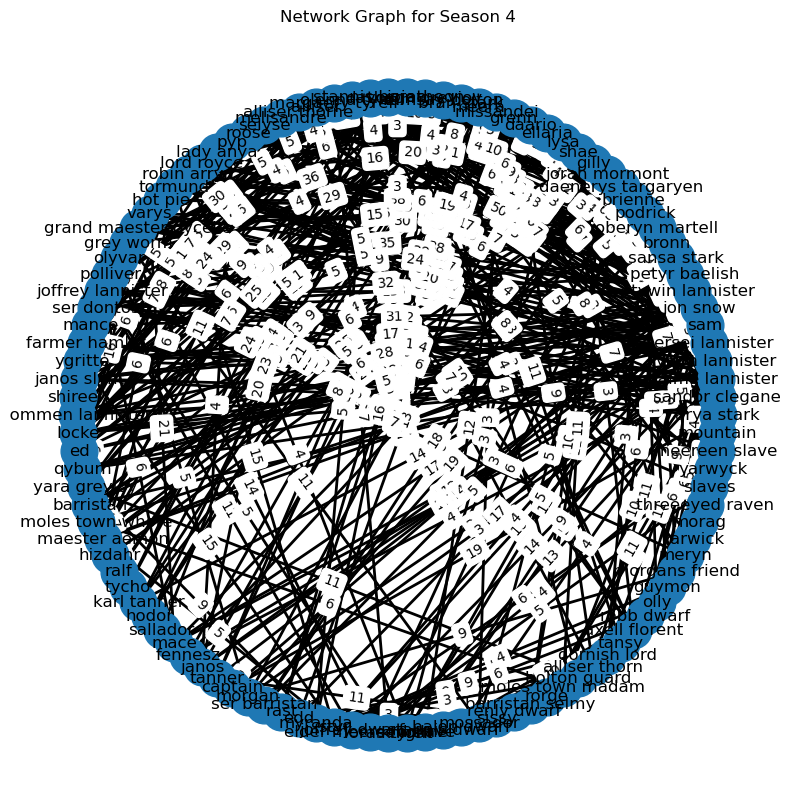

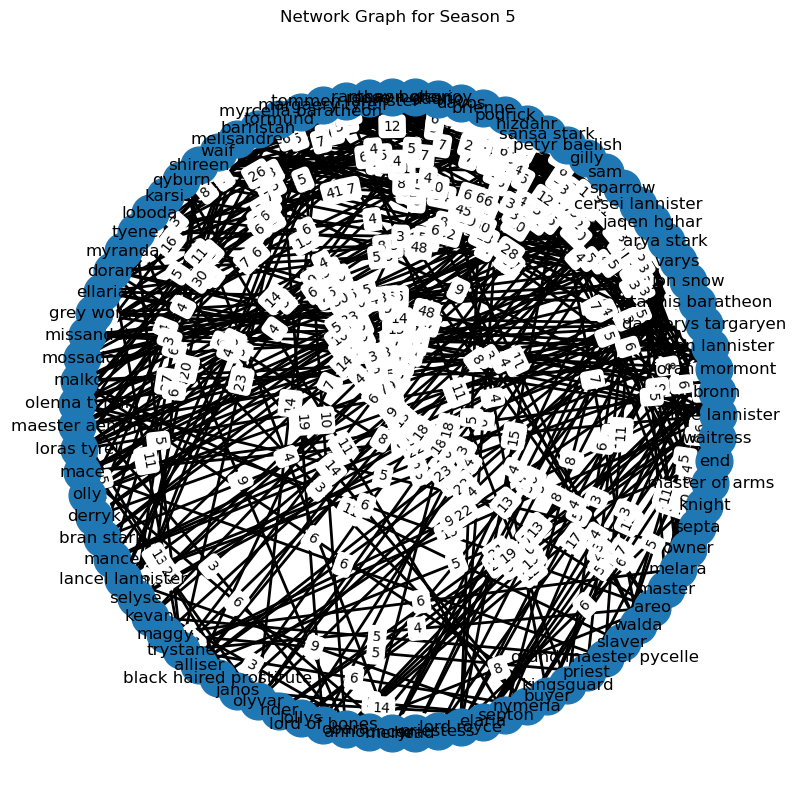

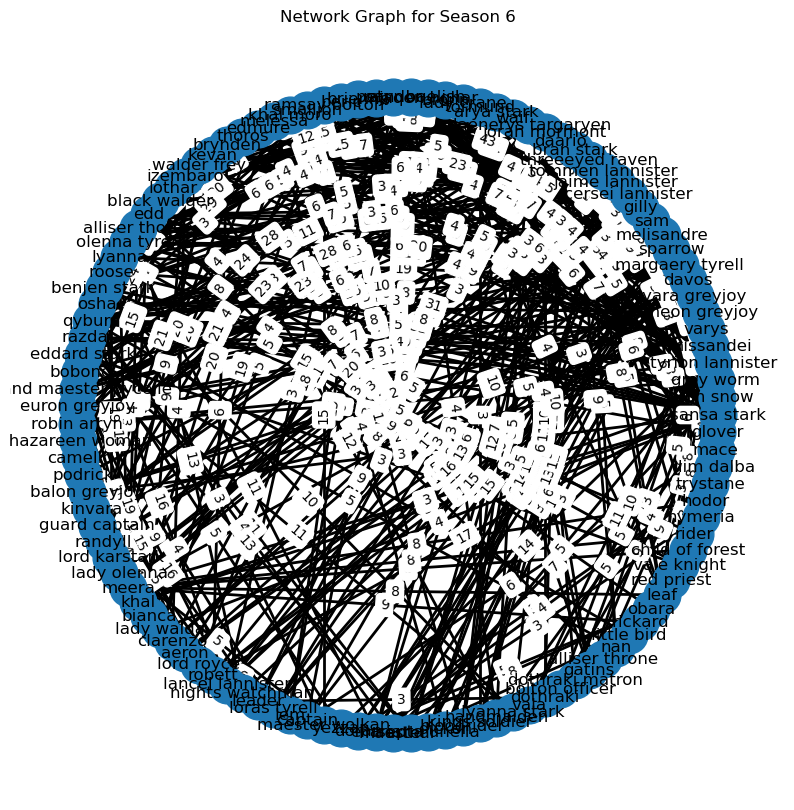

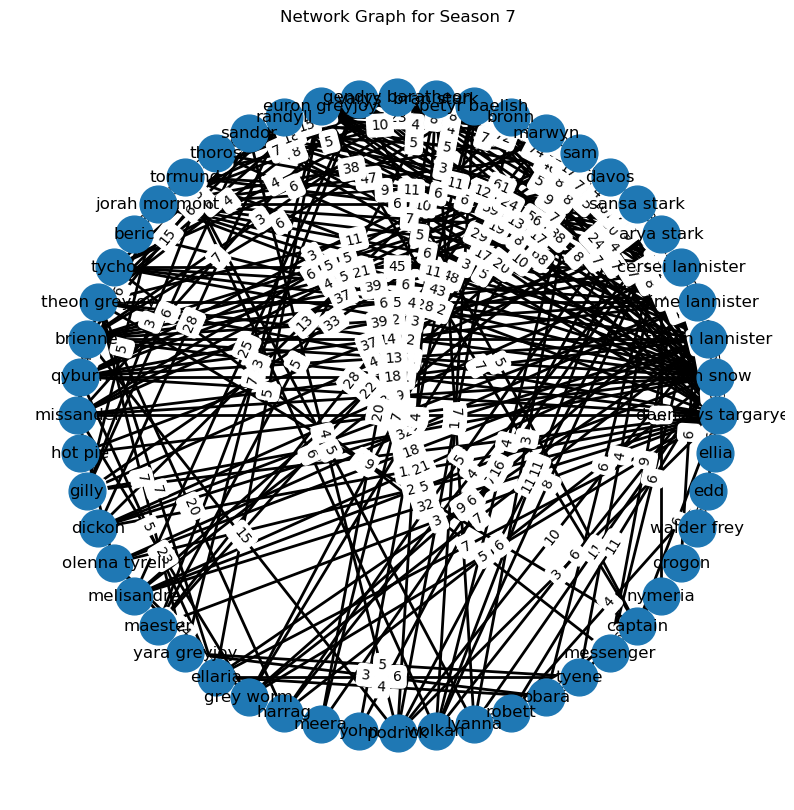

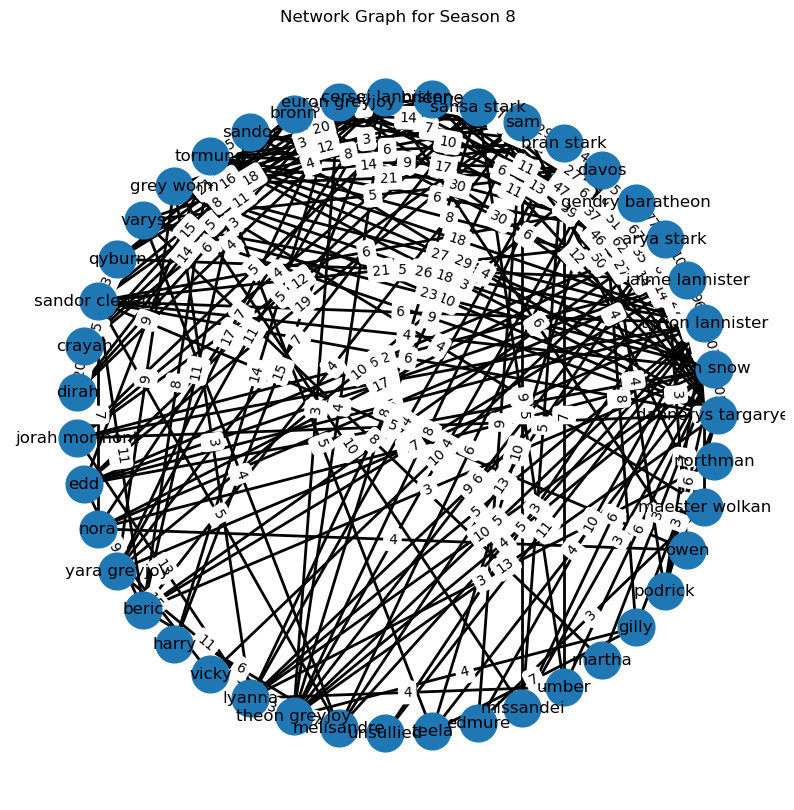

In [8]:
# Load the Excel file with interactions
excel_file = 'Game_of_Thrones_Filtered_Interactions.xlsx'
seasons_data = pd.read_excel(excel_file, sheet_name=None)  # Loads all sheets into a dictionary

# Function to build and visualize a network for a given season
def build_and_visualize_network(season_df, season_name):
    G = nx.Graph()

    # Adding edges and edge weights (interactions)
    for _, row in season_df.iterrows():
        characters = row['Characters'].split('-')
        interaction_count = row['Interactions']
        if interaction_count >= 3: # Only add ineractions with 3 or more interactions
            G.add_edge(characters[0], characters[1], weight=interaction_count)

    # Adding node attributes (total interactions)
    for node in G.nodes():
        total_interactions = sum([G[node][n]['weight'] for n in G.neighbors(node)])
        G.nodes[node]['total_interactions'] = total_interactions

    # Visualizing the network
    plt.figure(figsize=(10, 10))
    pos = nx.circular_layout(G)  # Circle layout
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))

    plt.title(f"Network Graph for {season_name}")
    plt.axis("off")
    plt.show()

    return G

# Building and visualizing networks for each season
networks = {}
for season in seasons_data:
    networks[season] = build_and_visualize_network(seasons_data[season], season)



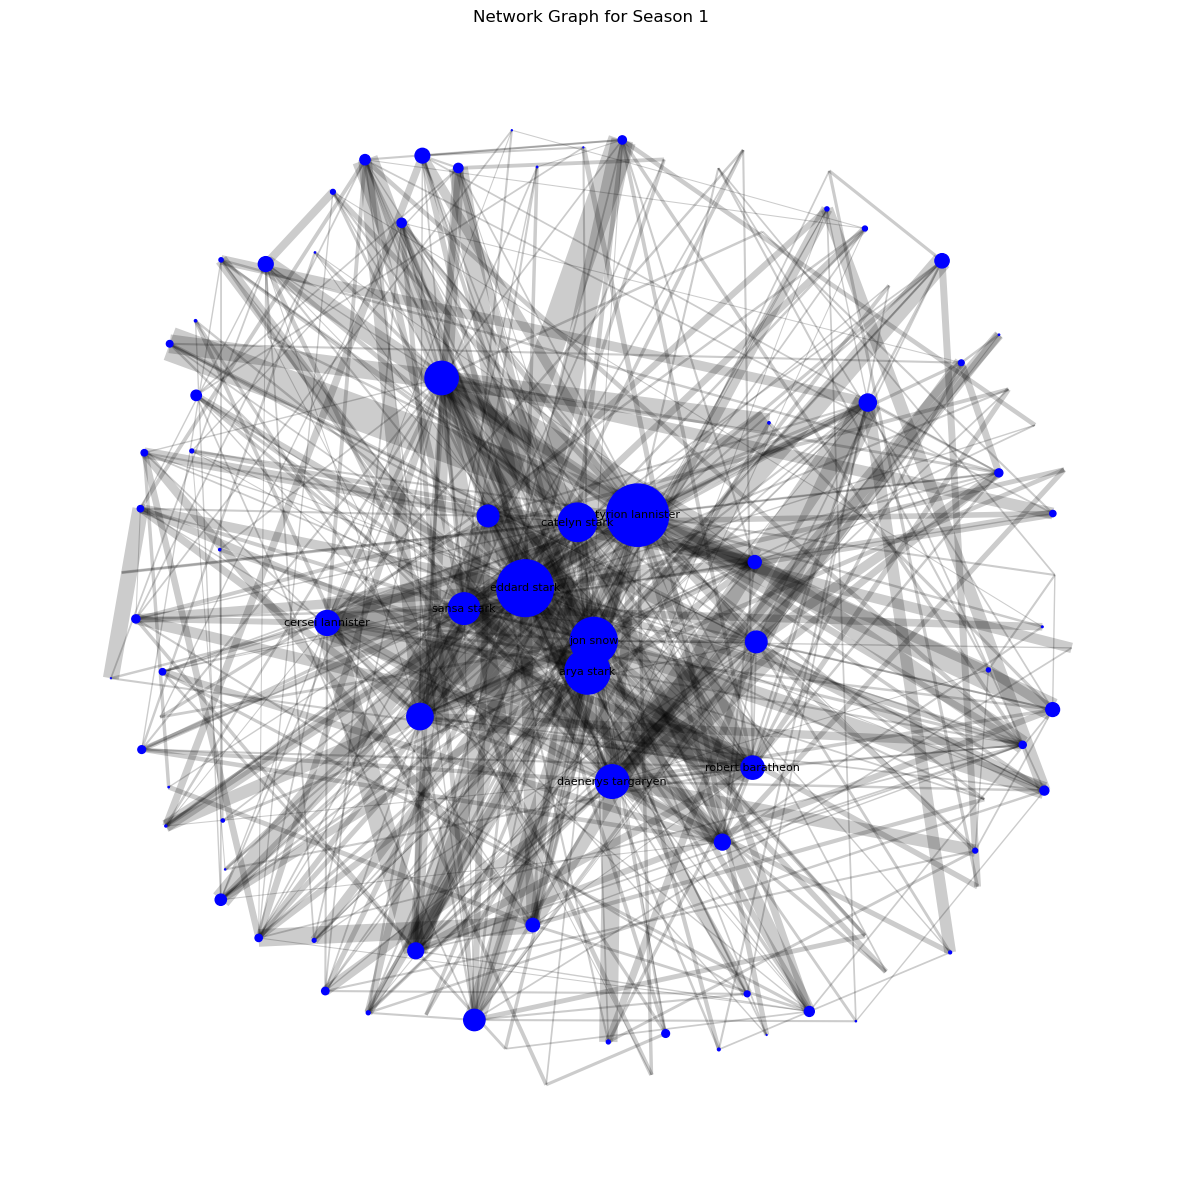

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming `networks` is your dictionary of graphs for each season

# Select a graph for a specific season to visualize
season_name = 'Season 1'  # Example season
G = networks[season_name]

# Calculate betweenness centrality and PageRank for the nodes
betweenness_centrality = nx.betweenness_centrality(G)
pagerank_centrality = nx.pagerank(G)

# Prepare the layout
pos = nx.spring_layout(G, k=5, iterations=50)

# Draw the graph
plt.figure(figsize=(15, 15))

# Draw edges
edges = G.edges(data=True)
edge_weights = [edata['weight']/4 for _, _, edata in edges]
nx.draw_networkx_edges(G, pos, alpha=0.2, width=edge_weights)

# Draw nodes
node_sizes = [betweenness_centrality[node] * 10000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')

# Draw node labels
# We will only label the top 10% nodes based on PageRank
sorted_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)
top_10_percent = sorted_pagerank[:len(sorted_pagerank) // 10]
node_labels = {node: node for node, _ in top_10_percent}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.title(f"Network Graph for {season_name}")
plt.axis('off')
plt.show()

# Code to save graph if we want to make some fancy graphs on Gephi
# Define the file path for each season's graph
file_path = f'network_season_{season_name}_hey.gexf'
# Write the graph to a GEXF file
nx.write_gexf(G, file_path)


C:\Users\boran\AppData\Local\Temp\ipykernel_16864\4194388823.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


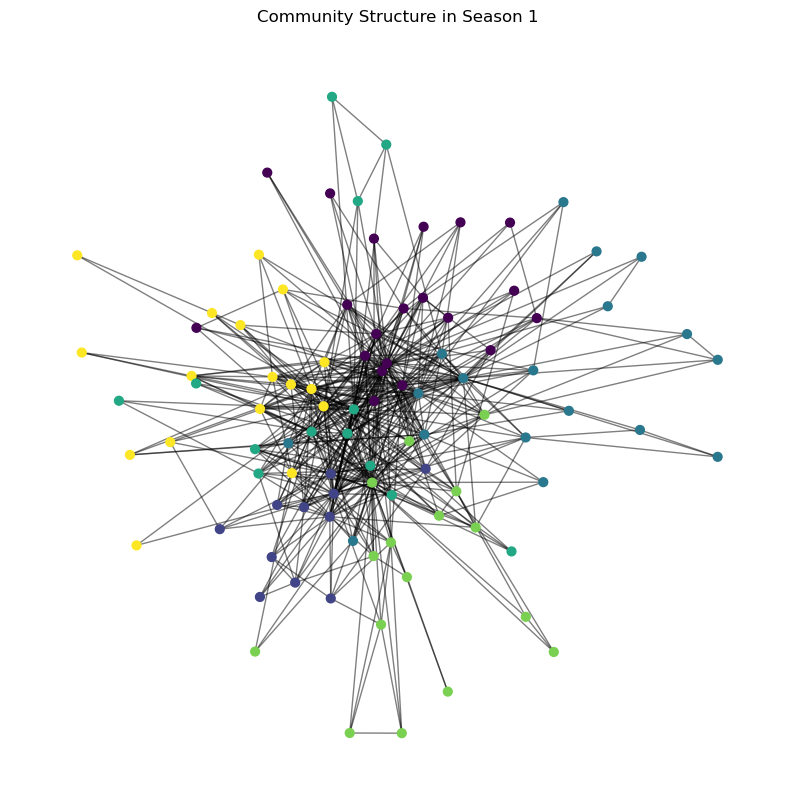

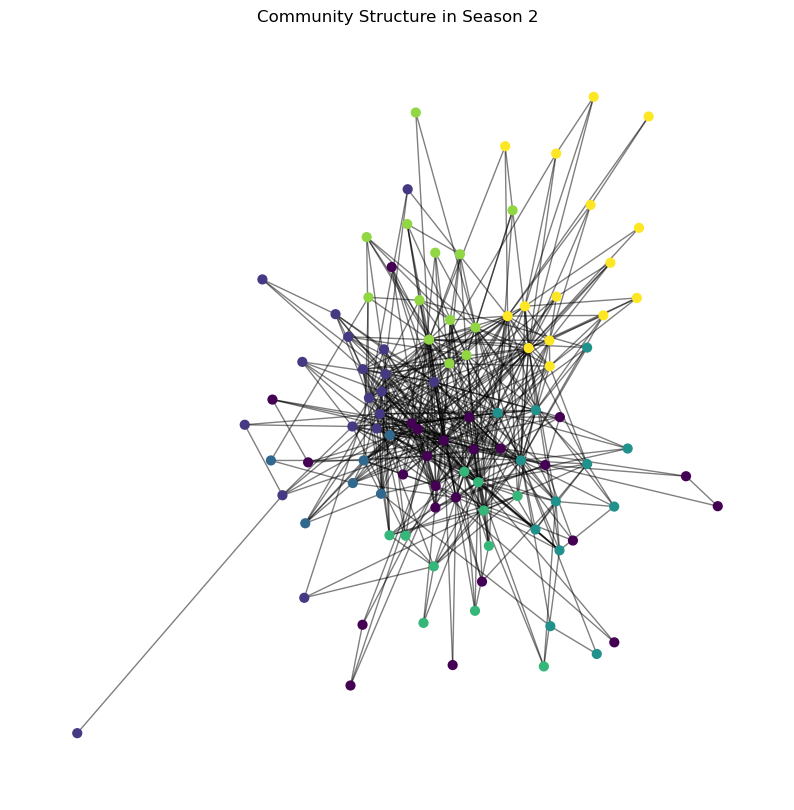

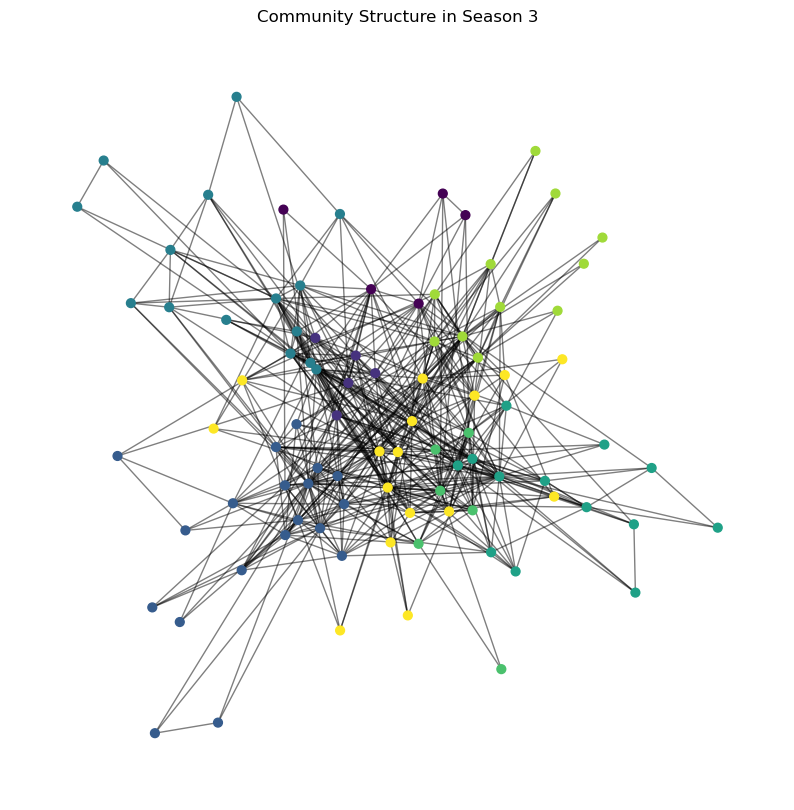

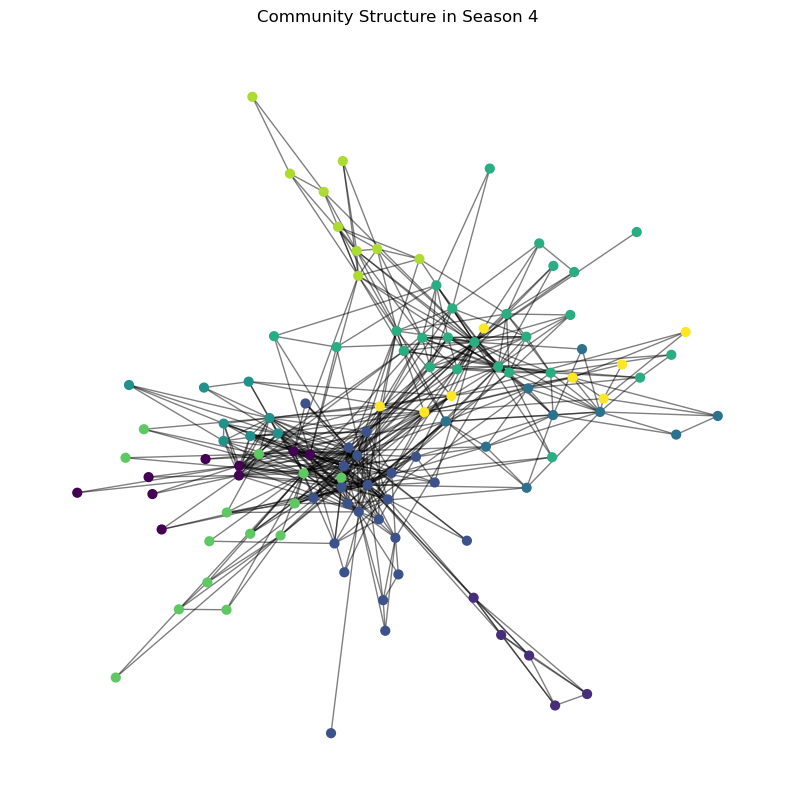

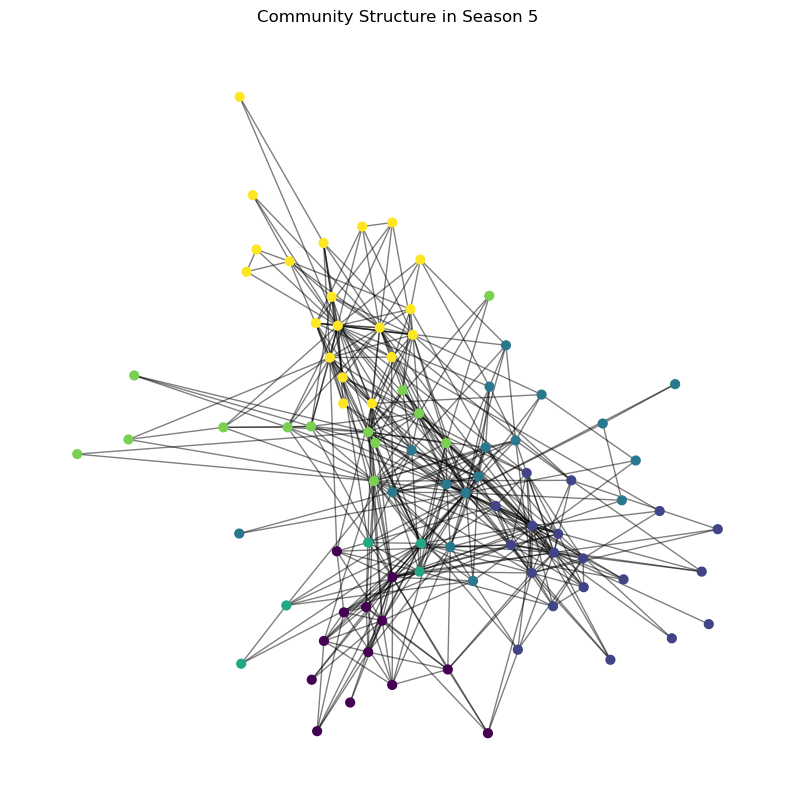

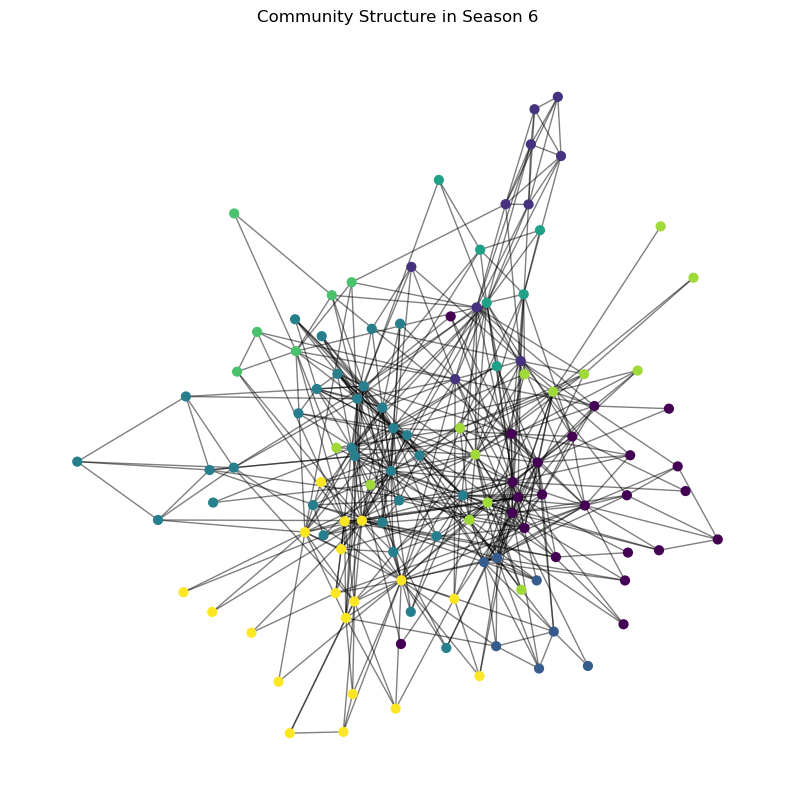

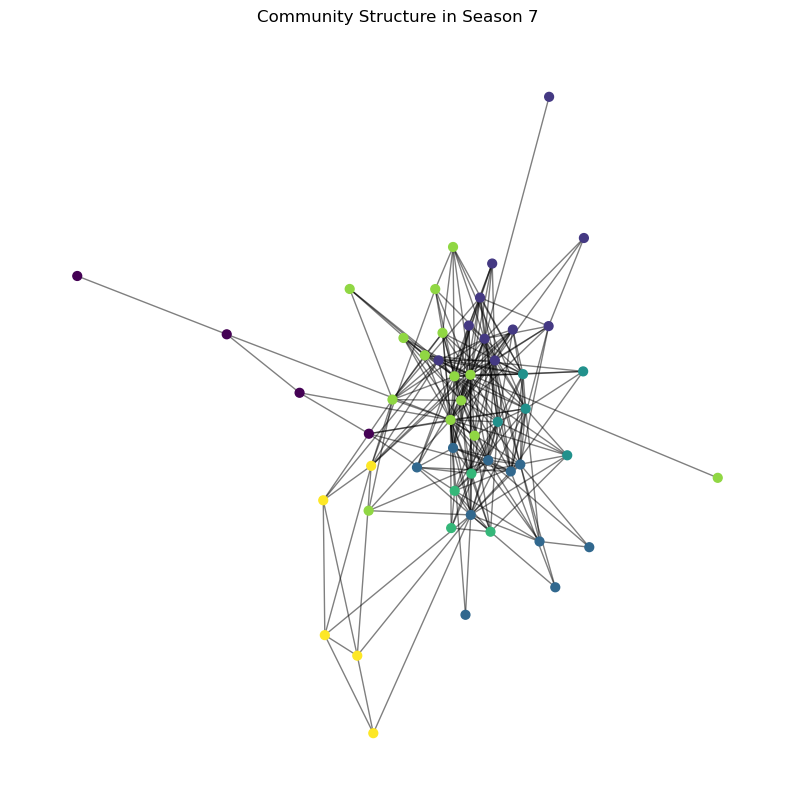

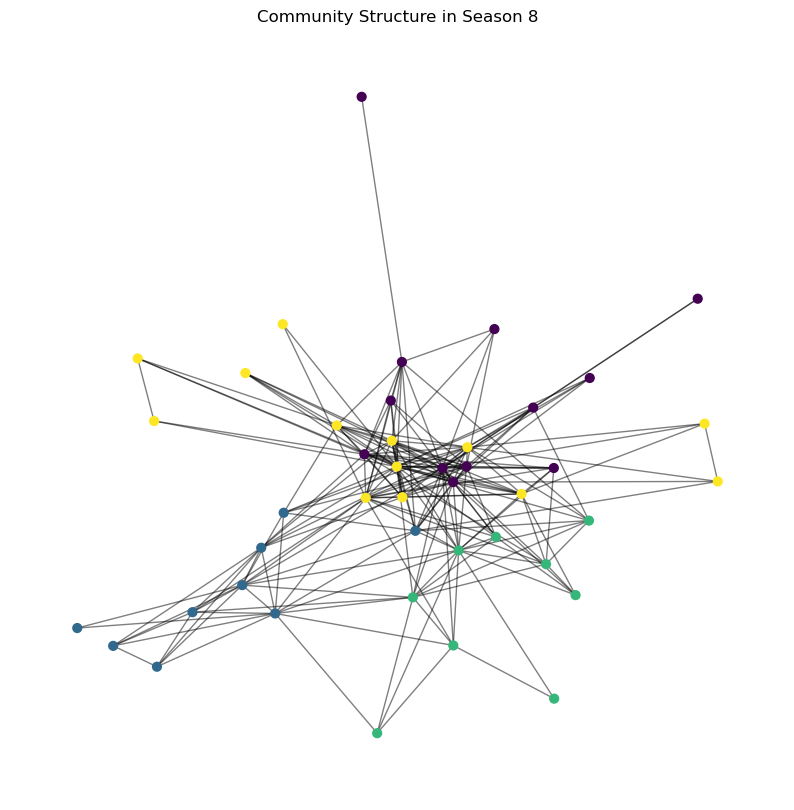

In [16]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Assuming `networks` is your dictionary containing the network for each season
community_networks = {}

for season, network in networks.items():
    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(network)
    
    # Visualize the communities
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(network)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(network, pos, partition.keys(), node_size=40,
                           cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(network, pos, alpha=0.5)
    plt.title(f"Community Structure in {season}")
    plt.axis('off')
    plt.show()
    
    # Store the partition for later analysis
    community_networks[season] = partition


In [17]:
# Assuming community detection has been performed and community_networks is populated

def print_communities_for_season(community_partition, season):
    # Inverting the partition dictionary to group nodes by community
    communities = {}
    for node, comm_id in community_partition.items():
        communities.setdefault(comm_id, []).append(node)
    
    print(f"Season: {season}")
    for comm_id, nodes in communities.items():
        print(f"Community {comm_id}: {', '.join(nodes)}")
    print("\n")

# Applying the function to each season's partition
for season, partition in community_networks.items():
    print_communities_for_season(partition, season)


Season: Season 1
Community 0: eddard stark, robert baratheon, petyr baelish, cersei lannister, varys, grand maester pycelle, jaime lannister, jory cassel, renly baratheon, loras tyrell, lord varys, barristan selmy, gendry baratheon, tobho mott, lancel lannister, illyrio mopatis, hugh of vale, steward, janos slynt, mhaegen
Community 1: daenerys targaryen, jorah mormont, viserys targaryen, mirri maz duur, rakharo, doreah, qotho, illyrio, drogo, wine merchant, irri
Community 2: arya stark, sansa stark, joffrey lannister, septa mordane, syrio forel, mordane, meryn trant, marillion, king joffrey, sandor clegane, mycah, lommy greenhands, hot pie, kings landing baker, stable boy, kings guard, street urchin, kings landing page
Community 3: sam, jon snow, jeor mormont, grenn, pyp, maester aemon, alliser thorne, othell yarwyck, will, waymar royce, gared, pypar, nights watcher
Community 4: shae, tyrion lannister, bronn, tywin lannister, lysa arryn, benjen stark, kevan lannister, yoren, mord, robi

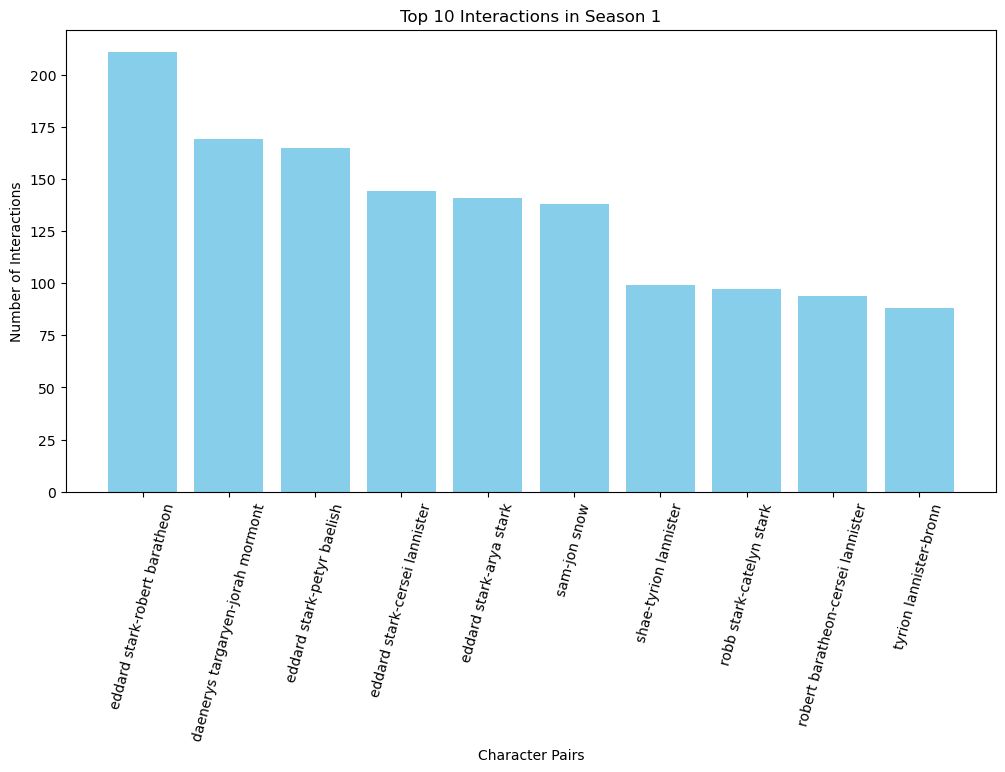

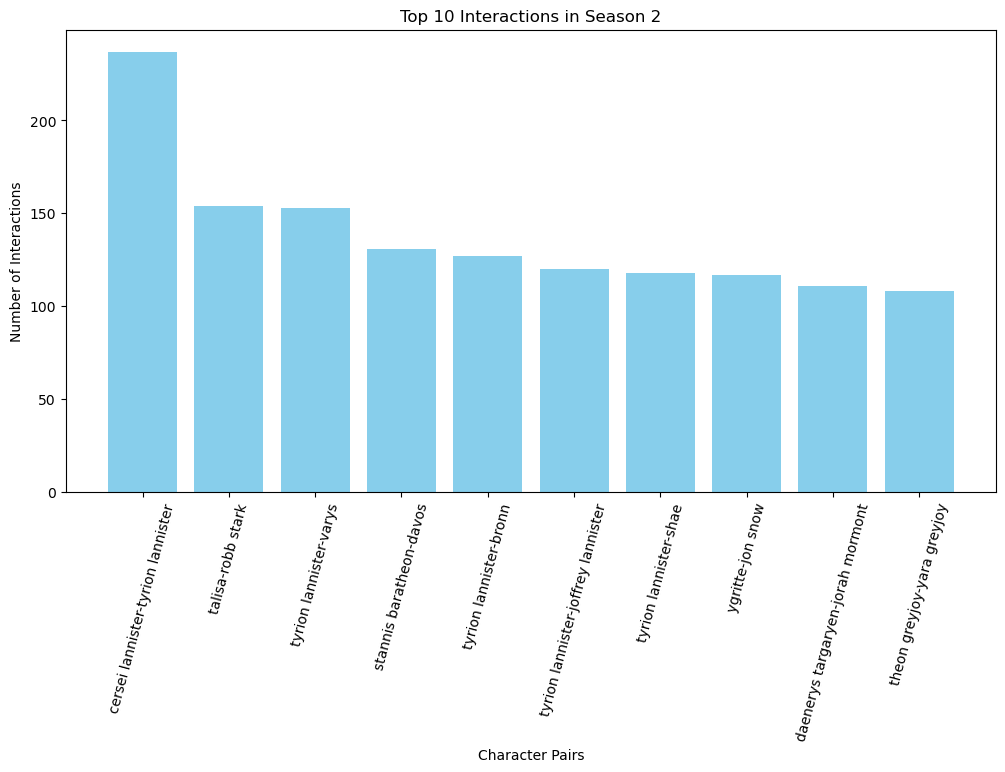

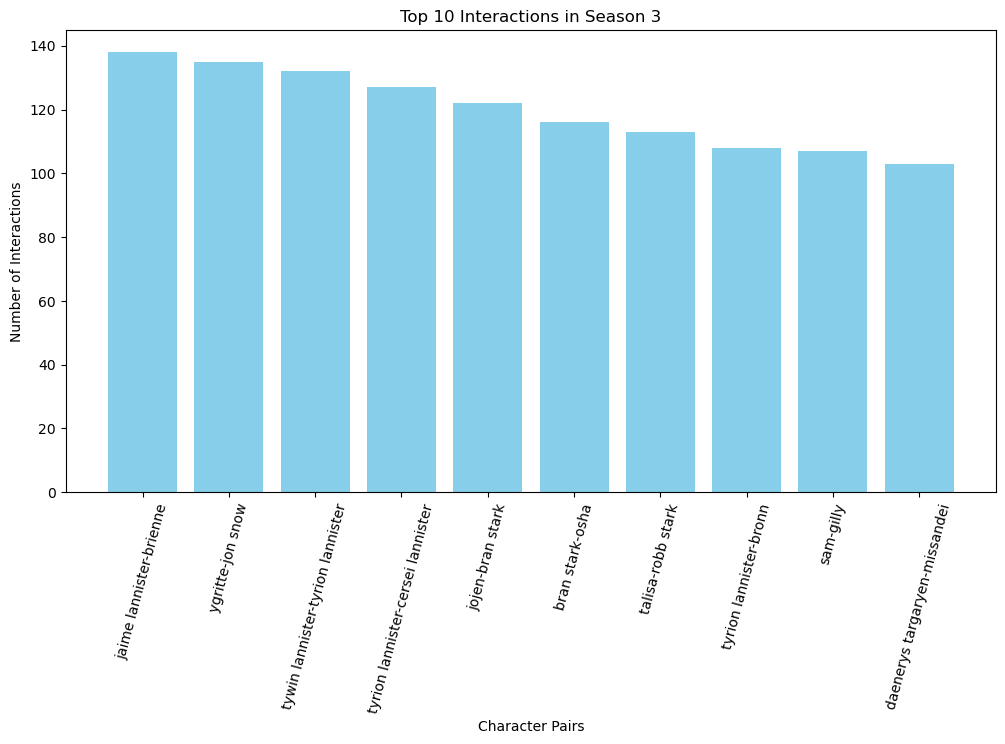

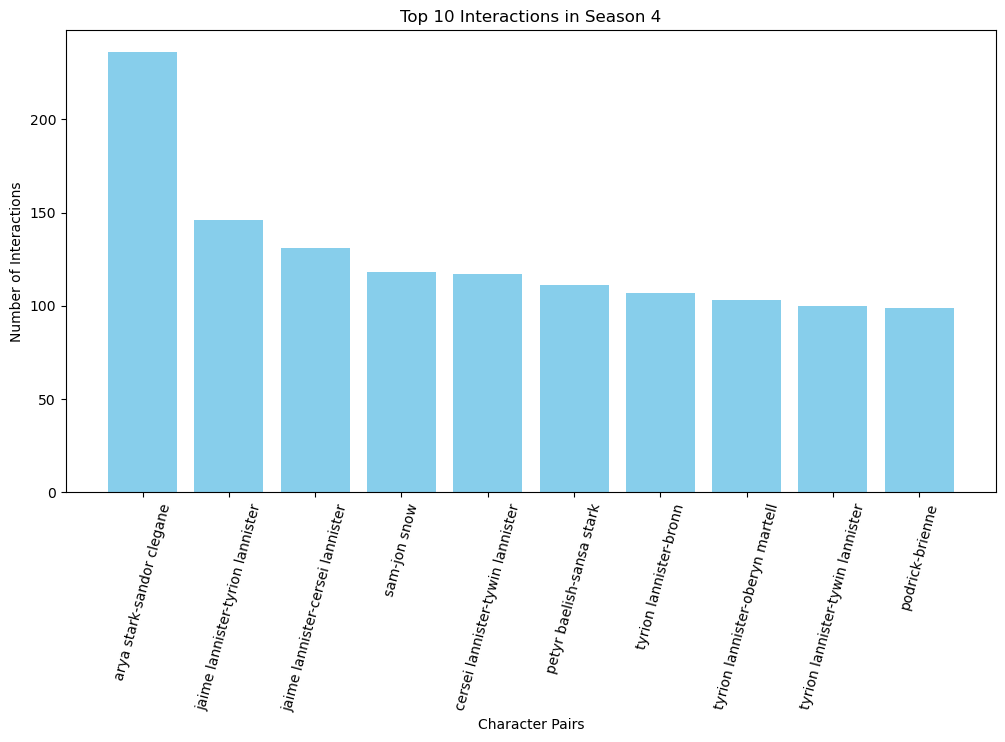

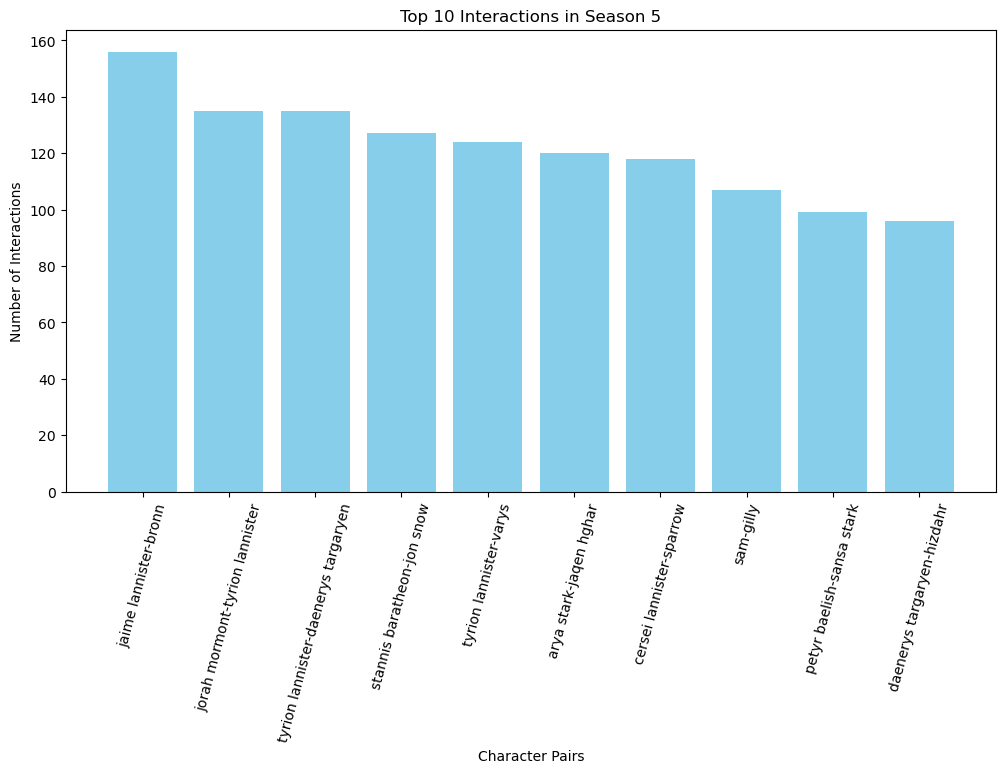

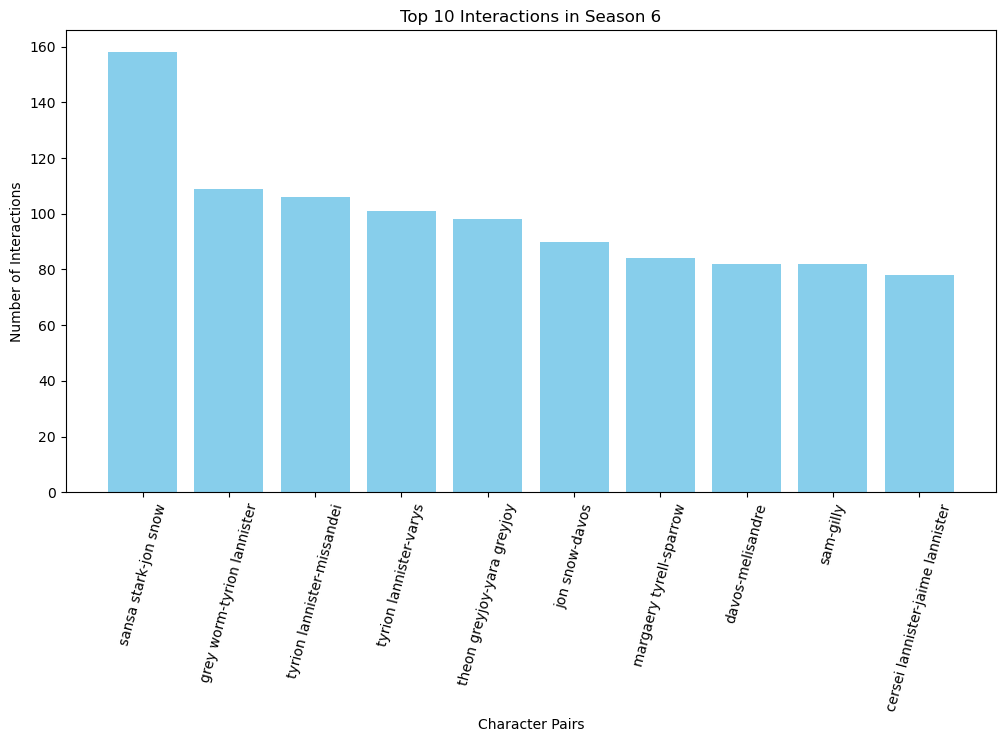

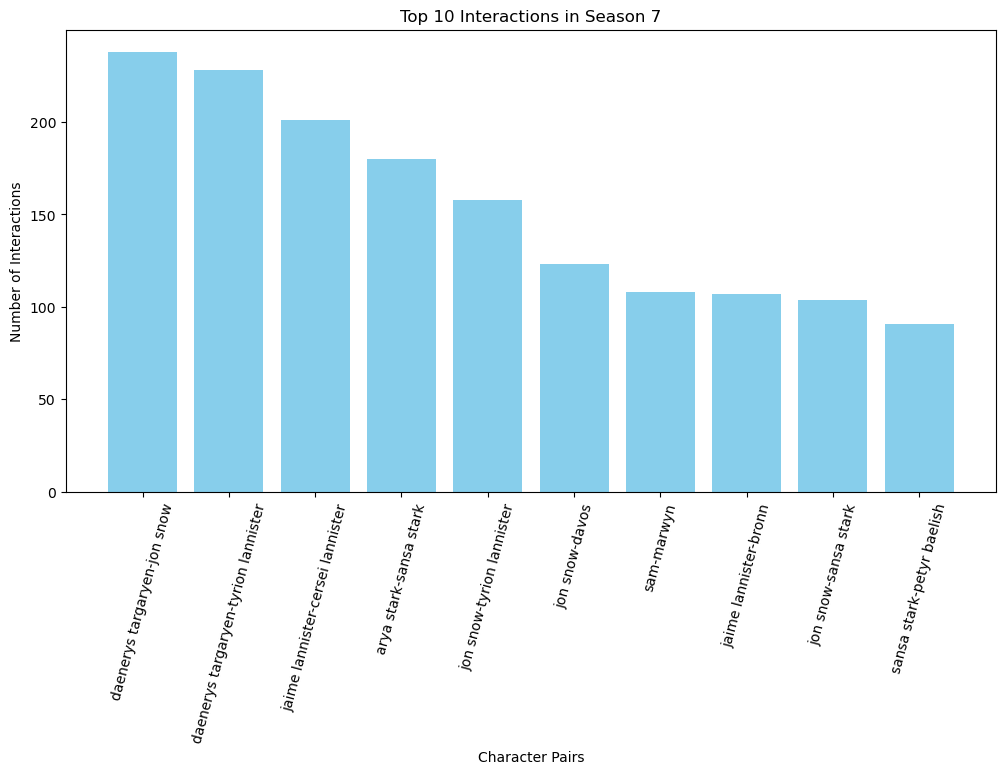

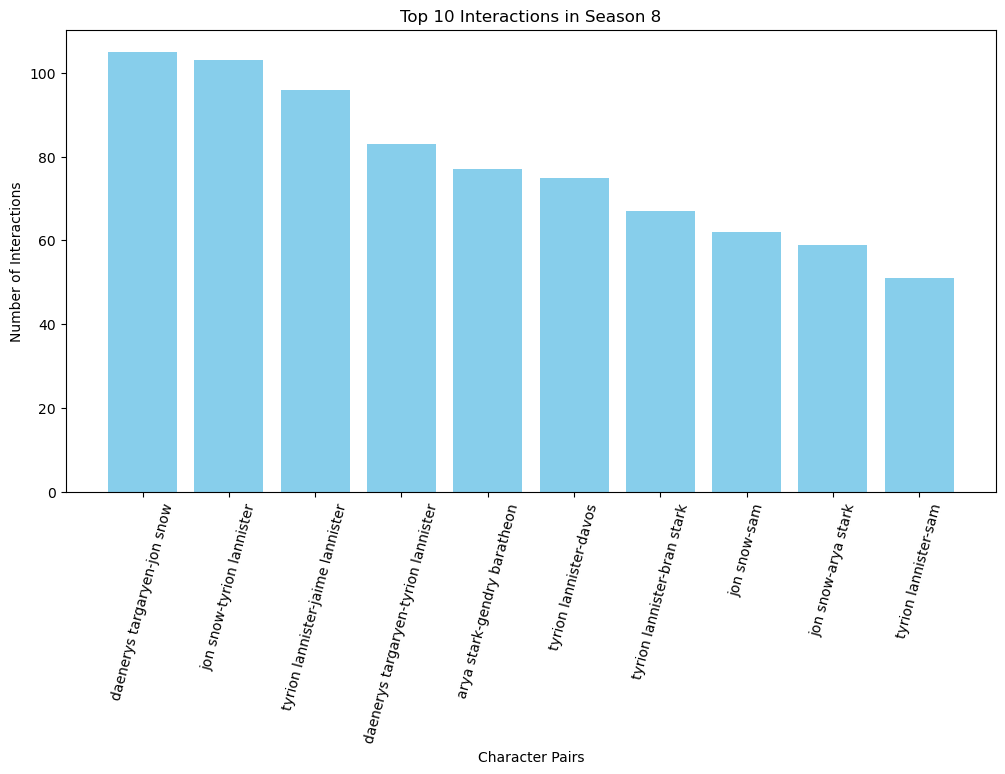

In [11]:
# Function to plot top 10 interactions for each season in a barplot
def plot_top_interactions_filtered(network, season_name, top_n=10):
    # Extract interactions and their weights (number of interactions)
    interactions = [(u, v, d['weight']) for u, v, d in network.edges(data=True)]
    interactions.sort(key=lambda x: x[2], reverse=True)  # Sort by number of interactions

    # Select top interactions
    top_interactions = interactions[:top_n]

    # Prepare data for plotting
    labels = [f"{u}-{v}" for u, v, _ in top_interactions]
    values = [w for _, _, w in top_interactions]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Character Pairs')
    plt.ylabel('Number of Interactions')
    plt.title(f'Top {top_n} Interactions in {season_name}')
    plt.xticks(rotation=75)  # Adjust rotation here
    plt.show()

# Plotting top 10 interactions for each of the seasons
for season in networks:
    plot_top_interactions_filtered(networks[season], season)


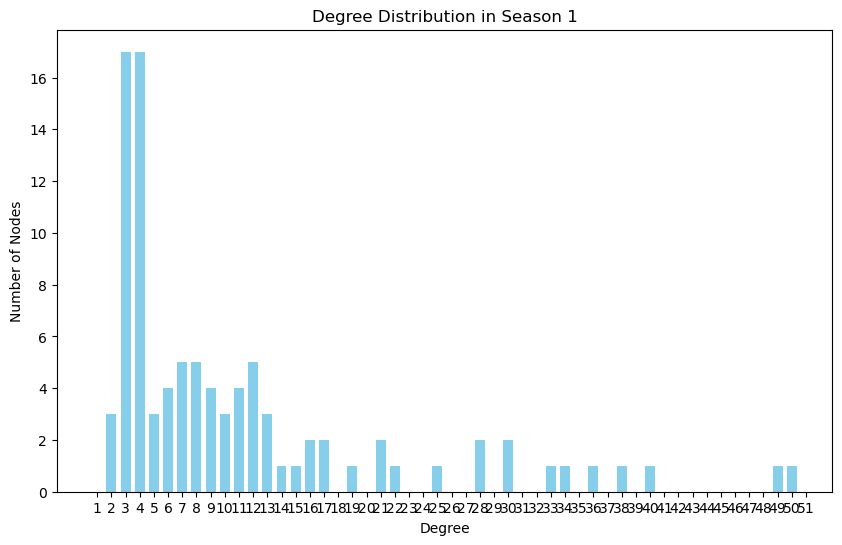

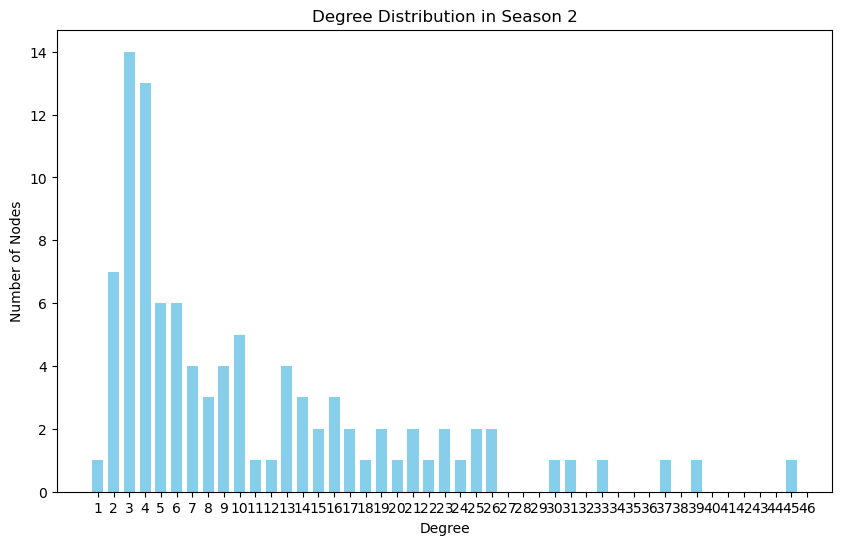

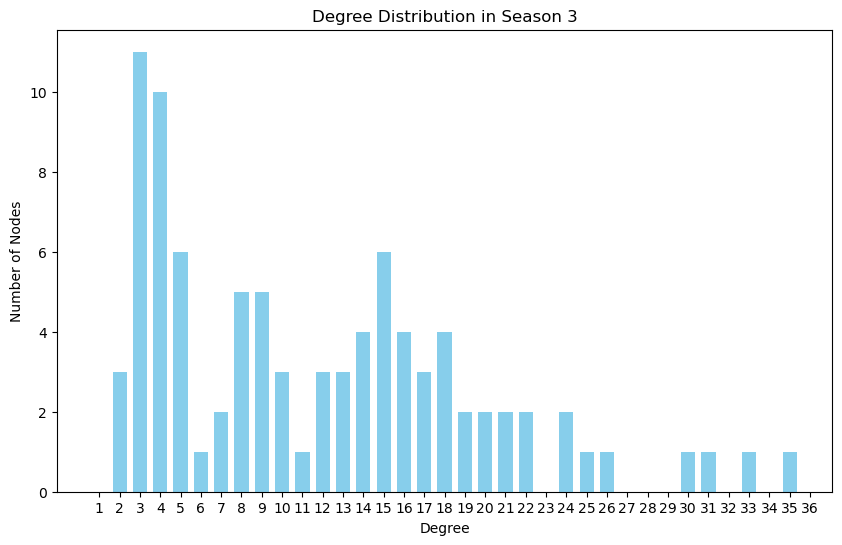

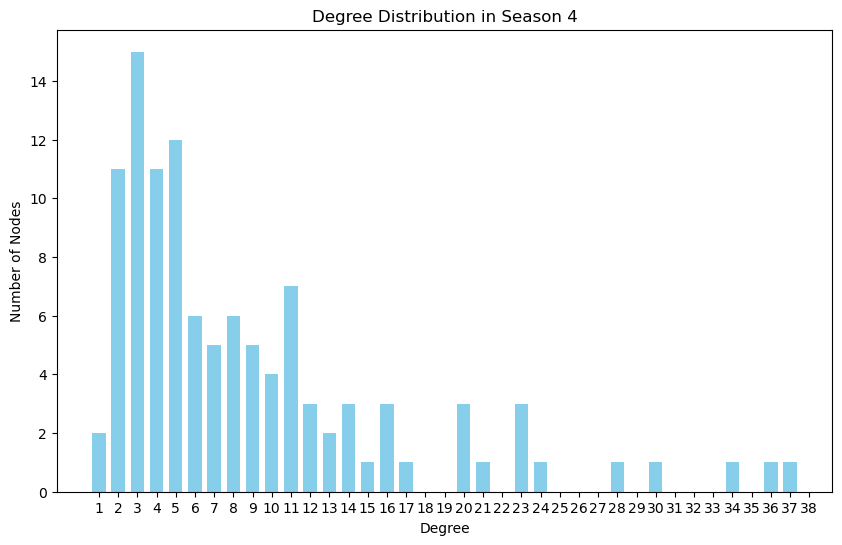

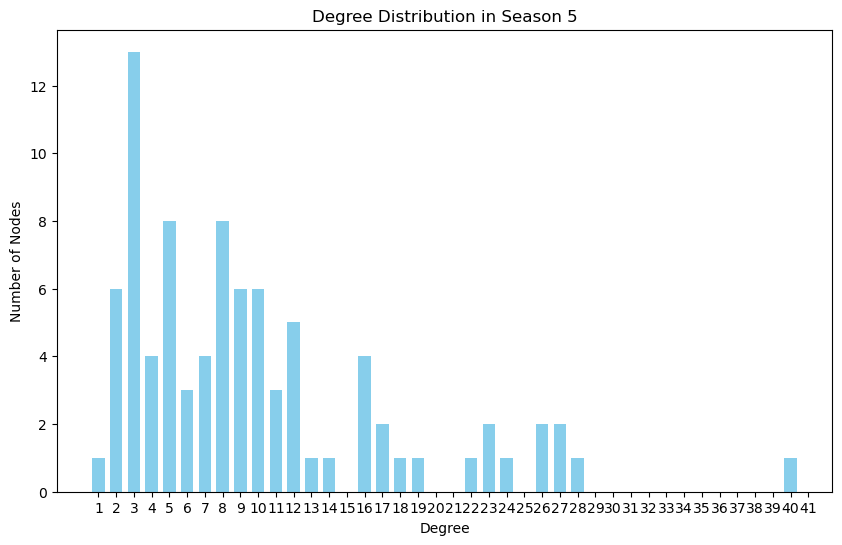

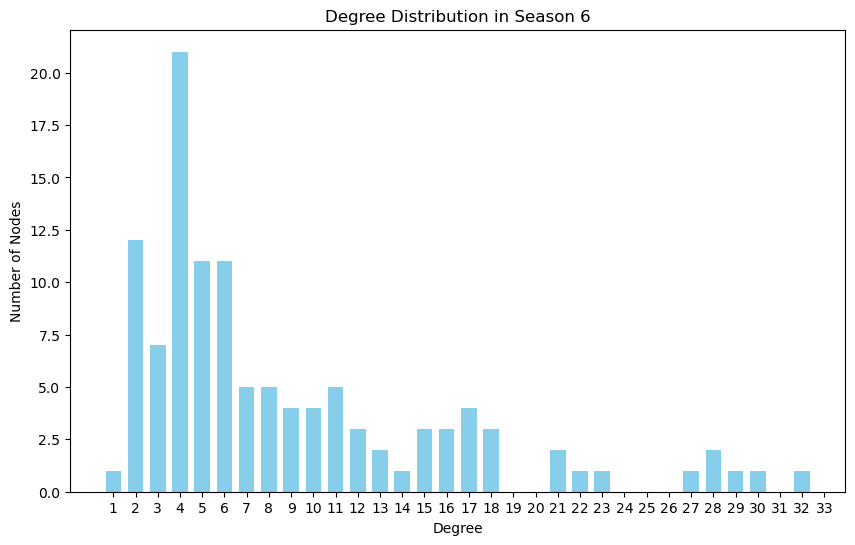

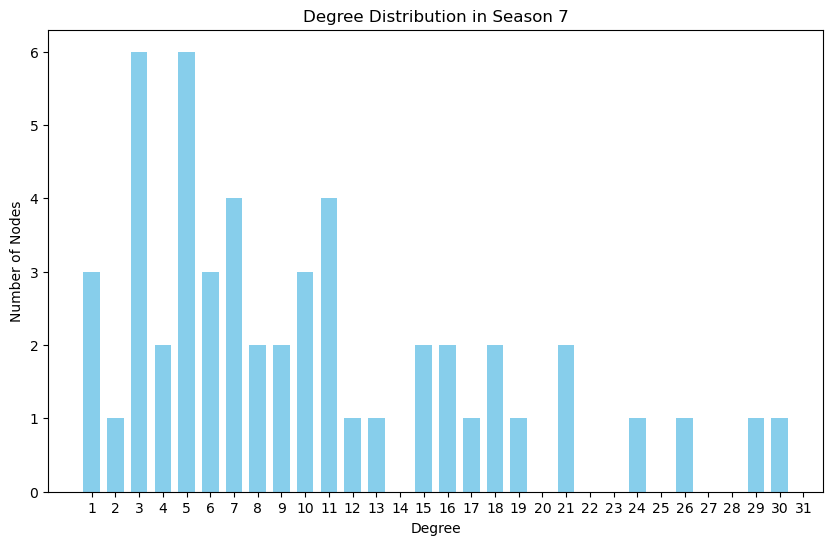

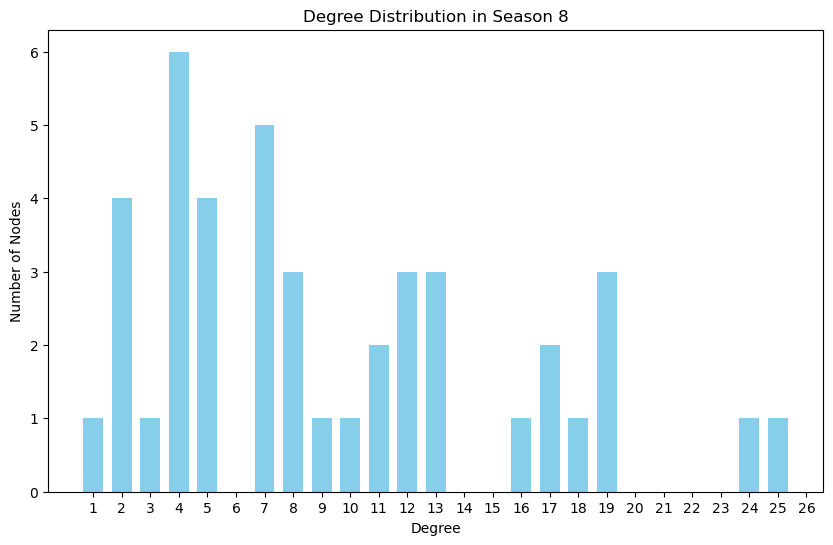

In [13]:
# Function to plot the degree distribution for each season
def plot_degree_distribution(network, season_name):
    degrees = [degree for _, degree in network.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=range(1, max(degrees)+1), align='left', rwidth=0.7, color='skyblue')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title(f'Degree Distribution in {season_name}')
    plt.xticks(range(1, max(degrees)+1))
    plt.show()

# Plotting degree distributions for each season
for season in networks:
    plot_degree_distribution(networks[season], season)


In [14]:
# Function to print the number of nodes, number of links, and top 5 most connected nodes for each season
def print_network_statistics(network, season_name):
    num_nodes = network.number_of_nodes()
    num_links = network.number_of_edges()
    
    # Calculating the degree for each node and sorting them
    degrees = dict(network.degree())
    sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

    # Top 5 most connected nodes
    top_5_nodes = sorted_degrees[:5]

    print(f"Season: {season_name}")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Links: {num_links}")
    print("Top 5 Most Connected Nodes:")
    for node, degree in top_5_nodes:
        print(f"  {node}: {degree} connections")
    print("\n")

# Printing statistics for each season
for season in networks:
    print_network_statistics(networks[season], season)


Season: Season 1
Number of Nodes: 95
Number of Links: 524
Top 5 Most Connected Nodes:
  eddard stark: 51 connections
  tyrion lannister: 49 connections
  jon snow: 40 connections
  catelyn stark: 38 connections
  daenerys targaryen: 36 connections


Season: Season 2
Number of Nodes: 99
Number of Links: 535
Top 5 Most Connected Nodes:
  tyrion lannister: 46 connections
  daenerys targaryen: 39 connections
  theon greyjoy: 37 connections
  arya stark: 33 connections
  jon snow: 31 connections


Season: Season 3
Number of Nodes: 90
Number of Links: 528
Top 5 Most Connected Nodes:
  tyrion lannister: 36 connections
  robb stark: 33 connections
  bran stark: 31 connections
  arya stark: 30 connections
  talisa: 26 connections


Season: Season 4
Number of Nodes: 110
Number of Links: 489
Top 5 Most Connected Nodes:
  tyrion lannister: 38 connections
  jon snow: 36 connections
  daenerys targaryen: 34 connections
  jaime lannister: 30 connections
  cersei lannister: 28 connections


Season: Se